# Market Basket Analysis: ricerca di frequent itemset e association rules


Scarichiamo i dati da Kaggle.

Bisogna registrarsi e creare un'API code.

Cliccare sull'icona con il proprio profilo in alto a destra

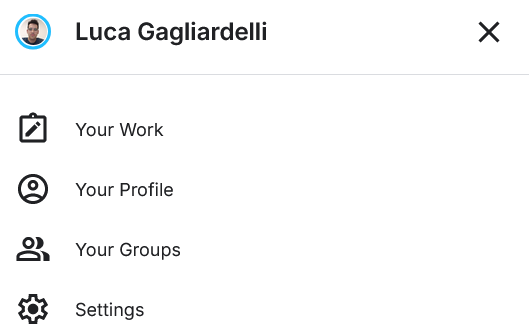


poi cliccare su "Settings".

Nella voce API cliccare su "Create New Token"

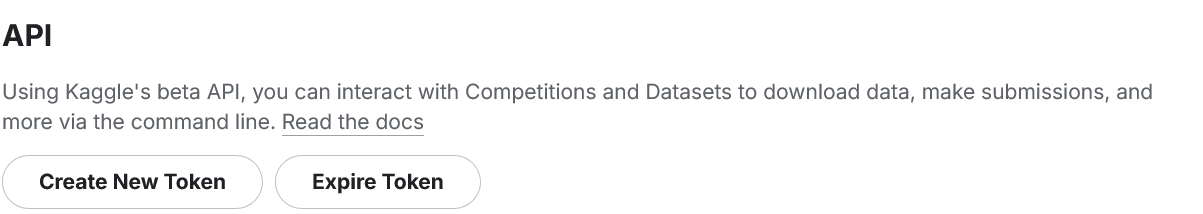


Scaricherà un file json che contiene il vostro username e un'API key.

Usando la seguente libreria è possibile scaricare dataset direttamente da Kaggle, basta inserire nel metodo `od.download` l'URL del dataset.

In [1]:
!pip install opendatasets -q

import opendatasets as od

od.download("https://www.kaggle.com/datasets/irfanasrullah/groceries")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: lucagagliardelli
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/irfanasrullah/groceries


100%|██████████| 168k/168k [00:00<00:00, 216MB/s]

Abbiamo visto che Scikit non implementa queste funzionalità, possiamo farlo con un’altra libreria di Python: Machine learning Extensions (https://rasbt.github.io/mlxtend/) che può essere installata con `pip install mlxtend` e poi importata con `import mlxtend`.

Questa libreria implementa due algoritmi per la ricerca di frequent itemsets:
*	Apriori: è un algoritmo classico e storicamente significativo. Tuttavia, risulta essere molto oneroso in termini di uso di memoria, poiché si basa sul principio che se un itemset è frequente, lo sono anche i suoi sottoinsiemi. Adotta quindi un approccio bottom-up: inizia considerando i singoli elementi (itemset di dimensione 1) e, iterativamente, genera itemset più grandi controllando se sono frequenti, fino a quando non si raggiunge itemset che non sono più frequenti o un limite massimo prefissato.
Generando gli itemset richiede molto tempo e memoria.
https://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/
*	FP-growth: è un’alternativa a Apriori, utilizza una struttura dati ad albero per il calcolo degli itemset frequenti, non deve generare tutti i possibili itemset, quindi è più efficiente.
https://rasbt.github.io/mlxtend/user_guide/frequent_patterns/fpgrowth

Entrambi gli algoritmi si aspettano in ingresso una matrice che riporta nelle colonne i prodotti (una colonna per ogni prodotto), nelle righe i basket, e ogni cella contiene 1 se il prodotto è inserito nel basket, altrimenti 0.

In [2]:
!pip install mlxtend -q
import mlxtend

Vediamo un esempio.

Utilizziamo questo dataset di Kaggle https://www.kaggle.com/datasets/irfanasrullah/groceries
Ogni riga del dataset rappresenta un basket, la prima colonna contiene il numero di prodotti nel basket, e poi a seguire i prodotti inseriti nel basket. Le colonne successive al numero di prodotti sono tutte nulle.

In [4]:
import pandas as pd
df = pd.read_csv('groceries/groceries - groceries.csv')
df.head()

,Item(s),Item 1,Item 2,Item 3,Item 4,Item 5,Item 6,Item 7,Item 8,Item 9,...,Item 23,Item 24,Item 25,Item 26,Item 27,Item 28,Item 29,Item 30,Item 31,Item 32
0,4,citrus fruit,semi-finished bread,margarine,ready soups,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,tropical fruit,yogurt,coffee,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,whole milk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,pip fruit,yogurt,cream cheese,meat spreads,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,other vegetables,whole milk,condensed milk,long life bakery product,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Dobbiamo inizialmente costruire la matrice. La libreria mette a disposizione una funzione per farlo chiamata `TransactionEncoder` (https://rasbt.github.io/mlxtend/user_guide/preprocessing/TransactionEncoder).

La funzione si aspetta in input una lista di itemset, dove un itemset è rappresentato da un elenco di prodotti.

Possiamo costruirla applicando una funzione che per ogni riga del dataframe: legge il numero di prodotti nel basket, converte la riga in una lista e estrae il numero corretto di elementi.

In [8]:
itemsets = df.apply(lambda x: x.tolist()[1:x["Item(s)"]+1], axis=1).tolist()
itemsets[0:2]

[['citrus fruit', 'semi-finished bread', 'margarine', 'ready soups'],
 ['tropical fruit', 'yogurt', 'coffee']]

Similmente a Scikit-learn anche questa libreria implementa i metodi fit e transform.

In [9]:
from mlxtend.preprocessing import TransactionEncoder

encoder = TransactionEncoder()
encoder.fit(itemsets)
matrix = pd.DataFrame(encoder.transform(itemsets), columns=encoder.columns_)
matrix.head()

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,baby food,bags,baking powder,bathroom cleaner,beef,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


Una volta fatto questo, possiamo applicare l’algoritmo per trovare gli itemset frequenti. Entrambi gli algoritmi prendono in ingresso la matrice e il supporto minimo che un itemset deve avere per essere considerato frequente.
Usiamo l’algoritmo apriori chiedendo che un itemset sia considerato frequente se compare in almeno il 2% dei carrelli.

Questo dataset è molto piccolo, quindi dobbiamo tenere una percentuale bassa per ottenere qualcosa.

In [11]:
from mlxtend.frequent_patterns import apriori

frequent_itemsets = apriori(matrix, min_support=0.02)

frequent_itemsets

,support,itemsets
0,0.033452,(1)
1,0.052466,(9)
2,0.033249,(10)
3,0.026029,(11)
4,0.080529,(12)
...,...,...
117,0.032232,"(162, 166)"
118,0.020742,"(162, 167)"
119,0.056024,"(166, 167)"
120,0.023183,"(124, 166, 103)"


Di default l’algoritmo ritorna un dataframe contenente gli itemset frequenti mostrati come l’indice di colonna e il loro supporto.
Il dataframe ha questo formato per essere utilizzato successivamente per scoprire le regole associative e occupare meno memoria.
Se si vuole un formato leggibile si può aggiungere il parametro use_colnames=True

In [12]:
frequent_itemsets = apriori(matrix, min_support=0.02, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.033452,(UHT-milk)
1,0.052466,(beef)
2,0.033249,(berries)
3,0.026029,(beverages)
4,0.080529,(bottled beer)
...,...,...
117,0.032232,"(whole milk, whipped/sour cream)"
118,0.020742,"(yogurt, whipped/sour cream)"
119,0.056024,"(yogurt, whole milk)"
120,0.023183,"(whole milk, other vegetables, root vegetables)"


Una volta determinati gli itemset frequenti, è possibile calcolare le regole associative utilizzando la funzione `association_rules` https://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/

La funzione prende in ingresso il dataframe dei frequent itemset generato con apriori o FP-growth, la metrica su cui valutare le regole associative trovate (di default usa la confidenza) e la soglia minima che la metrica deve avere affinché la regola sia considerata rilevante.

Ad esempio, possiamo trovare le regole con una confidenza di almeno il 45%

In [15]:
from mlxtend.frequent_patterns import association_rules

rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.45)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(butter),(whole milk),0.055414,0.255516,0.027555,0.497248,1.946053,1.0,0.013395,1.480817,0.514659,0.097237,0.324697,0.302543
1,(curd),(whole milk),0.053279,0.255516,0.026131,0.490458,1.919481,1.0,0.012517,1.461085,0.505984,0.092446,0.315577,0.296363
2,(domestic eggs),(whole milk),0.063447,0.255516,0.029995,0.472756,1.850203,1.0,0.013783,1.412030,0.490649,0.103800,0.291800,0.295073
3,"(whole milk, root vegetables)",(other vegetables),0.048907,0.193493,0.023183,0.474012,2.449770,1.0,0.013719,1.533320,0.622230,0.105751,0.347821,0.296912
4,"(other vegetables, root vegetables)",(whole milk),0.047382,0.255516,0.023183,0.489270,1.914833,1.0,0.011076,1.457687,0.501524,0.082879,0.313982,0.289999
5,"(yogurt, other vegetables)",(whole milk),0.043416,0.255516,0.022267,0.512881,2.007235,1.0,0.011174,1.528340,0.524577,0.080485,0.345695,0.300014


Possiamo vedere come la presenza del burro aumenti di 2 volte la probabilità (lift) di avere il latte intero.

Oppure come la presenza dello yogurt insieme ad altri ortaggi aumenti la probabilità di avere il latte intero di 2 volte.